Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Import** Libraries

In [0]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import re

Using TensorFlow backend.


Remove numeric and empty texts

In [0]:
TRAINING_DATA_DIR = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/training.1600000.processed.noemoticon.csv'

df = pd.read_csv(TRAINING_DATA_DIR, encoding ='ISO-8859-1', usecols = ['target', 'text'], error_bad_lines=False)
df['target'] = df['target'].map(lambda x : 1 if int(x) == 4 else 0)
df.sample(6)

,target,text
427664,0,I am home now. Still have no credit.
278836,0,I just lost around 200 followers out of nowher...
1019422,1,@packtplastik that's so cool. send me a link ...
965529,1,Photo: uaba: I shoot for the starsï¿½ http://...
1044375,1,Running on 3 hours of sleep at 2:30 in the mor...
322203,0,&lt;--------------HOW COME I STILL DONT HAVE O...


Balance and shuffle training data

In [0]:
df['target'].value_counts()

0    799999
1    248576
Name: target, dtype: int64

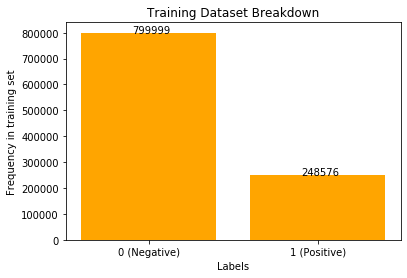

In [0]:
x = [0, 1]
y = [df['target'].value_counts()[0], df['target'].value_counts()[1]]
training_breakdown = plt.bar(x, y, color='orange')
plt.xlabel('Labels')
plt.ylabel('Frequency in training set')
plt.xticks(x, ['0 (Negative)', '1 (Positive)'])
plt.title('Training Dataset Breakdown')

for i, v in enumerate(y):
    plt.text(x[i] - 0.10, v, str(v))

plt.show()

In [0]:
pos_df = df.loc[df['target'] == 1]
neg_df = df.loc[df['target'] == 0].sample(248576)
normalized_df = pd.concat([neg_df, pos_df])
normalized_df_shuffled = normalized_df.sample(frac=1)

In [0]:
normalized_df_shuffled['target'].value_counts()

1    248576
0    248576
Name: target, dtype: int64

Clean and stem training data

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.stem.snowball import SnowballStemmer
def clean_text(text):

  ## Remove URLs
  text = re.sub(r" http.* \/", "", text)
  text = re.sub(r" .*\.com", "", text)

  ## Remove puncuation
  text = text.translate(string.punctuation)

  ## Convert words to lower case and split them
  text = text.lower().split()

  ## Remove stop words and words beginning with '@'
  stops = set(stopwords.words("english"))
  text = [w for w in text if not w in stops and w[0] != '@' and len(w) >= 3]
  text = " ".join(text)

  ## Clean the text
  removelist = '!?'
  text = re.sub(r'[^\w'+removelist+']', ' ',text)
  text = re.sub(r"!", " ! ", text)
 
  text = re.sub(r" u s ", " american ", text)
  text = re.sub(r"\0s", "0", text)
  text = re.sub(r" 9 11 ", "911", text)
  text = re.sub(r"e - mail", "email", text)
  text = re.sub(r"j k", "jk", text)
  text = re.sub(r"\s{2,}", " ", text)
    
  ## Stemming
  text = text.split()
  stemmer = SnowballStemmer('english')
  stemmed_words = [stemmer.stem(word) for word in text]
  text = " ".join(stemmed_words)
 
  return text

In [0]:
# apply the above function to normalized_df_shuffled['text']
normalized_df_shuffled['text'] = normalized_df_shuffled['text'].map(lambda x: clean_text(x))
normalized_df_shuffled.sample(6)

,target,text
858107,1,final excit go florida
469622,0,go miss you
895516,1,costco much better get much littl
1035409,1,ate come visit wit differ weather
144600,0,hate
661988,0,nearest orang julius omaha mile away


Tokenize training data

In [0]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(normalized_df_shuffled['text'])

input_length = 25
sequences = tokenizer.texts_to_sequences(normalized_df_shuffled['text'])
data = pad_sequences(sequences, maxlen=input_length)

Get Glove embeddings

In [0]:
glove_dims = 100
GLOVE_100D_DIR = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/glove.twitter.27B/glove.twitter.27B.100d.txt'
GLOVE_25D_DIR = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/glove.twitter.27B/glove.twitter.27B.25d.txt'

embeddings_index = dict()
f = open(GLOVE_100D_DIR)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, glove_dims))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Develop model

In [0]:
from keras import layers, backend

model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, glove_dims, input_length=input_length, weights=[embedding_matrix]))
model_glove.add(layers.Lambda(lambda x: backend.mean(x, axis=1)))
model_glove.add(Dense(1, activation='tanh'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
labels = normalized_df_shuffled['target']
model_glove.fit(data, np.array(labels), validation_split=0.2, epochs = 5)



Train on 397721 samples, validate on 99431 samples
Epoch 1/5
397721/397721 [==============================] - 193s 485us/step - loss: 0.5848 - acc: 0.7306 - val_loss: 0.5595 - val_acc: 0.7505
Epoch 2/5
397721/397721 [==============================] - 192s 483us/step - loss: 0.5546 - acc: 0.7465 - val_loss: 0.5725 - val_acc: 0.7085
Epoch 3/5
397721/397721 [==============================] - 195s 490us/step - loss: 0.5461 - acc: 0.7541 - val_loss: 0.5681 - val_acc: 0.7520
Epoch 4/5
397721/397721 [==============================] - 193s 485us/step - loss: 0.5471 - acc: 0.7483 - val_loss: 0.5812 - val_acc: 0.7503
Epoch 5/5
397721/397721 [==============================] - 194s 489us/step - loss: 0.5404 - acc: 0.7550 - val_loss: 0.5647 - val_acc: 0.7512


LDA Helpers

In [0]:
MODEL_TYPE = 'logreg'
SANDY_HOOK = 'sandyhook'
VEGAS = 'vegas'
BERNARDINO = 'bernardino'
ORLANDO = 'orlando'
PARKLAND = 'parkland'
SHOOTINGS = [SANDY_HOOK, BERNARDINO, ORLANDO, VEGAS, PARKLAND]
SHOOTINGS_TEST_DIR_PREFIX = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/TestData'
SHOOTINGS_TEST_DIR_SUFFIXES = {SANDY_HOOK:'/Sandy Hook 2012', BERNARDINO:'/Bernardino 2015', ORLANDO:'/Orlando 2016', VEGAS:'/Vegas 2017', PARKLAND:'/Parkland 2018'}
SHOOTINGS_PRED_DIR_PREFIX = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/TestPredictions'
SHOOTINGS_PRED_DIR_SUFFIXES = {SANDY_HOOK:'/Sandy Hook 2012 Predictions', BERNARDINO:'/Bernardino 2015 Predictions', ORLANDO:'/Orlando 2016 Predictions', VEGAS:'/Vegas 2017 Predictions', PARKLAND:'/Parkland 2018 Predictions'}
NUM_SAMPLED = 300
FIRST_DAY = -4
LAST_DAY = 55
THRESHOLD = 0.3

def get_dirs(shooting, day):
  test_dir = '{}{}'.format(SHOOTINGS_TEST_DIR_PREFIX, SHOOTINGS_TEST_DIR_SUFFIXES[shooting])
  pred_dir = '{}{}'.format(SHOOTINGS_PRED_DIR_PREFIX, SHOOTINGS_PRED_DIR_SUFFIXES[shooting])
  test_day_file_name = '{}_{}_{}.csv'.format(shooting, day, NUM_SAMPLED)
  test_day_dir = '{}/{}'.format(test_dir, test_day_file_name)
  pred_day_file_name = '{}_{}_{}_{}_preds.csv'.format(shooting, day, NUM_SAMPLED, MODEL_TYPE)
  pred_day_dir = '{}/{}'.format(pred_dir, pred_day_file_name)
  return test_day_dir, pred_day_dir

def tokenize_test_data(cleaned_test_df):
  tokenizer = Tokenizer(num_words=vocabulary_size)
  tokenizer.fit_on_texts(cleaned_test_df['text'])

  sequences = tokenizer.texts_to_sequences(cleaned_test_df['text'])
  test_data = pad_sequences(sequences, maxlen=input_length)
  return test_data

def get_label(pred_y):
  if pred_y <= THRESHOLD:
    return 0
  else:
    return 1

import csv
from gensim import corpora, models
def predict_file(test_file_dir, test_pred_file_dir, shooting_offtopic_idx, lda_map_dict):
  test_df = pd.read_csv(test_file_dir, encoding ='ISO-8859-1', usecols=[0], names=['text'], error_bad_lines=False)
  cleaned_test_df = test_df
  cleaned_test_df['text'] = cleaned_test_df['text'].map(lambda x: clean_text(x))
  test_data = tokenize_test_data(cleaned_test_df)

  f = open(test_pred_file_dir, 'w')
  with f:
    writer = csv.writer(f)
    writer.writerow(['score', 'label'])
    for i, example in enumerate(test_data):
      example_text = cleaned_test_df['text'][i]
      if lda_map_dict[example_text] and lda_map_dict[example_text] not in shooting_offtopic_idx:
        pred_y = model_glove.predict(np.expand_dims(example, axis=0))[0][0]
        label = get_label(pred_y)
        writer.writerow([example_text, str(pred_y), str(label)])
  f.close()

Build LDA Model

In [83]:
import csv
from gensim import corpora, models
import nltk
nltk.download('stopwords')

lda_map_dict = dict()
def getAllTweetWordLists(list_of_list_of_tokens,test_file_dir, test_pred_file_dir, curr_tweet_id):
  test_df = pd.read_csv(test_file_dir, encoding ='ISO-8859-1', usecols=[0], names=['text'], error_bad_lines=False)
  clean_test_df = test_df
  cleaned_test_df = test_df
  cleaned_test_df['text'] = cleaned_test_df['text'].map(lambda x: clean_text(x))
  test_data = tokenize_test_data(cleaned_test_df)

  # LDA make model
  for tweet in cleaned_test_df['text']:
    lda_map_dict[tweet] = curr_tweet_id
    curr_tweet_id += 1
    list_of_list_of_tokens.append(tweet.split(' '))
  return list_of_list_of_tokens, curr_tweet_id

def getLDAModel(shootingName, numTopics, numWords):
  vocabulary_size = 20000
  list_of_list_of_tokens = []
  num_topics = numTopics
  num_words = numWords
  curr_tweet_id = 0
  for day in range(FIRST_DAY, LAST_DAY + 1):
    test_day_dir, pred_day_dir = get_dirs(shootingName, day)
    #test_day_dir = '/content/drive/My Drive/CS 221 Final Project/Final Project Files/TestData/Sandy Hook 2012/sandyhook_1_300.csv'
    #pred_day_dir = '/content/drive/My Drive/CS 221 Final Project/Final Project Files/TestPredictions/Sandy Hook 2012 Predictions/sandyhook_1_300_logreg_preds.csv'
    list_of_list_of_tokens, curr_tweet_id = getAllTweetWordLists(list_of_list_of_tokens, test_day_dir, pred_day_dir, curr_tweet_id)
  dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
  dictionary_LDA.filter_extremes(no_below=3)
  corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]
  lda_model = models.LdaModel(corpus, num_topics=numTopics, id2word=dictionary_LDA, passes=4, alpha=[0.01]*numTopics, eta=[0.01]*len(dictionary_LDA.keys()))
  topics = lda_model.show_topics(formatted=True, num_topics=numTopics, num_words=numWords)
  return lda_model, corpus, topics

def printEnumTopics(topics):
  ind = 0
  for i,topic in topics:
    print("topic #" + str(ind)+ "; with ID:" + str(i) + " is " + str(topic))
    ind += 1

def getTopicForTweetInd(model, mycorpus, topics, ind):
  lda_model = model
  corpus = mycorpus
  print("corpus is len" + str(len(corpus)))
  # ind = 2
  # BOW embedding
  #print(corpus[ind])
  #lemmatized/tokenized tweet
  #print(list_of_list_of_tokens[ind])
  # Closest topic see above
  print(list_of_list_of_tokens[ind])
  maxlikelihood = -1
  topicchosen = -1
  print(lda_model[corpus[ind]])
  for a in lda_model[corpus[ind]]:
    if a[1] > maxlikelihood:
      maxlikelihood = a[1]
      topicchosen = a[0]
  print("Most likely topic: " + str(topicchosen) + "\n And the topic is: "+ str(topics[topicchosen]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Testing

In [84]:
sandyhook_lda_model, sandyhook_corpus, sandyhook_topics = getLDAModel(SANDY_HOOK, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [85]:
printEnumTopics(sandyhook_topics)
ind = 4
getTopicForTweetInd(sandyhook_lda_model, sandyhook_corpus, sandyhook_topics, ind)
print()
print(str(lda_map_dict['teacher sandi hook crazi precaut']))

topic #0; with ID:0 is 0.162*"congress" + 0.050*"thank" + 0.043*"god"
topic #1; with ID:1 is 0.125*"beauti" + 0.125*"america" + 0.062*"school"
topic #2; with ID:2 is 0.062*"youtub" + 0.060*"perform" + 0.038*"tcot"
topic #3; with ID:3 is 0.099*"shooter" + 0.069*"adam" + 0.063*"lanza"
topic #4; with ID:4 is 0.033*"man" + 0.031*"2012" + 0.030*"movi"
topic #5; with ID:5 is 0.055*"peopl" + 0.048*"gun" + 0.045*"take"
topic #6; with ID:6 is 0.046*"receiv" + 0.043*"would" + 0.035*"stage"
topic #7; with ID:7 is 0.089*"use" + 0.051*"15" + 0.049*"obama"
topic #8; with ID:8 is 0.045*"get" + 0.041*"t" + 0.039*"award"
topic #9; with ID:9 is 0.057*"say" + 0.052*"happen" + 0.048*"parent"
topic #10; with ID:10 is 0.161*"conspiraci" + 0.158*"video" + 0.082*"like"
topic #11; with ID:11 is 0.086*"i" + 0.069*"m" + 0.044*"fulli"
topic #12; with ID:12 is 0.140*"super" + 0.095*"school" + 0.084*"elementari"
topic #13; with ID:13 is 0.048*"citizen" + 0.040*"game" + 0.039*"video"
topic #14; with ID:14 is 0.131*"

In [126]:
sandy_hook_offtopic_idx = {2, 6, 8, 11}
shooting = SANDY_HOOK
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, sandy_hook_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

logreg predictions made for sandyhook


In [87]:
vegas_lda_model, vegas_corpus, vegas_topics = getLDAModel(VEGAS, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [88]:
printEnumTopics(vegas_topics)
ind = 4
getTopicForTweetInd(vegas_lda_model, vegas_corpus, vegas_topics, ind)

topic #0; with ID:0 is 0.067*"play" + 0.066*"win" + 0.066*"free"
topic #1; with ID:1 is 0.130*"http" + 0.100*"video" + 0.095*"like"
topic #2; with ID:2 is 0.050*"hit" + 0.040*"hour" + 0.033*"crash"
topic #3; with ID:3 is 0.073*"new" + 0.039*"5" + 0.038*"game"
topic #4; with ID:4 is 0.034*"would" + 0.031*"think" + 0.030*"gun"
topic #5; with ID:5 is 0.061*"las" + 0.054*"night" + 0.038*"2"
topic #6; with ID:6 is 0.038*"look" + 0.036*"next" + 0.033*"year"
topic #7; with ID:7 is 0.048*"lasvega" + 0.043*"strip" + 0.034*"free"
topic #8; with ID:8 is 0.064*"las" + 0.032*"shoot" + 0.032*"attack"
topic #9; with ID:9 is 0.089*"las" + 0.047*"http" + 0.044*"victim"
topic #10; with ID:10 is 0.064*"las" + 0.061*"http" + 0.047*"run"
topic #11; with ID:11 is 0.043*"las" + 0.027*"top" + 0.022*"miss"
topic #12; with ID:12 is 0.041*"peopl" + 0.041*"las" + 0.034*"casino"
topic #13; with ID:13 is 0.080*"las" + 0.054*"nevada" + 0.048*"http"
topic #14; with ID:14 is 0.136*"https" + 0.123*"las" + 0.091*"via"
t

In [127]:
vegas_offtopic_idx = {0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 16, 19}
shooting = VEGAS
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, vegas_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

logreg predictions made for vegas


In [93]:
bernardino_lda_model, bernardino_corpus, bernardino_topics = getLDAModel(BERNARDINO, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [94]:
printEnumTopics(bernardino_topics)
ind = 4
getTopicForTweetInd(bernardino_lda_model, bernardino_corpus, bernardino_topics, ind)

topic #0; with ID:0 is 0.132*"fbi" + 0.065*"return" + 0.064*"say"
topic #1; with ID:1 is 0.086*"gun" + 0.064*"obama" + 0.040*"shoot"
topic #2; with ID:2 is 0.100*"call" + 0.082*"cordillera" + 0.079*"centenario"
topic #3; with ID:3 is 0.257*"avail" + 0.185*"i" + 0.175*"m"
topic #4; with ID:4 is 0.159*"s" + 0.065*"claim" + 0.052*"visa"
topic #5; with ID:5 is 0.118*"terrorist" + 0.084*"attack" + 0.071*"sourc"
topic #6; with ID:6 is 0.064*"poor" + 0.062*"mass" + 0.058*"good"
topic #7; with ID:7 is 0.062*"like" + 0.039*"million" + 0.036*"get"
topic #8; with ID:8 is 0.075*"health" + 0.039*"job" + 0.035*"deni"
topic #9; with ID:9 is 0.105*"california" + 0.065*"fbi" + 0.062*"man"
topic #10; with ID:10 is 0.083*"public" + 0.081*"moder" + 0.080*"18"
topic #11; with ID:11 is 0.127*"bomb" + 0.110*"news" + 0.051*"woman"
topic #12; with ID:12 is 0.110*"minut" + 0.089*"ask" + 0.071*"help"
topic #13; with ID:13 is 0.195*"!" + 0.078*"counti" + 0.034*"job"
topic #14; with ID:14 is 0.066*"kill" + 0.064*"

In [128]:
bernardino_offtopic_idx = {2, 3, 7, 10, 12, 16, 17}
shooting = BERNARDINO
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, bernardino_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

logreg predictions made for bernardino


In [96]:
orlando_lda_model, orlando_corpus, orlando_topics = getLDAModel(ORLANDO, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [97]:
printEnumTopics(orlando_topics)
ind = 4
getTopicForTweetInd(orlando_lda_model, orlando_corpus, orlando_topics, ind)

topic #0; with ID:0 is 0.049*"play" + 0.047*"move" + 0.043*"0"
topic #1; with ID:1 is 0.054*"drive" + 0.035*"celebr" + 0.034*"miami"
topic #2; with ID:2 is 0.064*"http" + 0.052*"gun" + 0.048*"call"
topic #3; with ID:3 is 0.093*"http" + 0.071*"free" + 0.056*"via"
topic #4; with ID:4 is 0.113*"i" + 0.085*"m" + 0.042*"see"
topic #5; with ID:5 is 0.051*"http" + 0.040*"game" + 0.037*"red"
topic #6; with ID:6 is 0.083*"mlg" + 0.056*"go" + 0.040*"weekend"
topic #7; with ID:7 is 0.056*"got" + 0.050*"re" + 0.048*"we"
topic #8; with ID:8 is 0.066*"http" + 0.066*"citi" + 0.051*"s"
topic #9; with ID:9 is 0.269*"bloom" + 0.098*"kati" + 0.094*"perri"
topic #10; with ID:10 is 0.068*"night" + 0.064*"s" + 0.046*"http"
topic #11; with ID:11 is 0.049*"justin" + 0.045*"new" + 0.043*"ride"
topic #12; with ID:12 is 0.065*"need" + 0.040*"s" + 0.039*"pleas"
topic #13; with ID:13 is 0.068*"t" + 0.045*"can" + 0.042*"wait"
topic #14; with ID:14 is 0.145*"http" + 0.083*"victim" + 0.076*"shoot"
topic #15; with ID:

In [129]:
orlando_offtopic_idx = {0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19}
shooting = ORLANDO
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, orlando_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

logreg predictions made for orlando


In [99]:
parkland_lda_model, parkland_corpus, parkland_topics = getLDAModel(PARKLAND, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [100]:
printEnumTopics(parkland_topics)
ind = 4
getTopicForTweetInd(parkland_lda_model, parkland_corpus, parkland_topics, ind)

topic #0; with ID:0 is 0.034*"student" + 0.032*"support" + 0.022*"real"
topic #1; with ID:1 is 0.092*"https" + 0.088*"shoot" + 0.081*"http"
topic #2; with ID:2 is 0.085*"shooter" + 0.021*"would" + 0.021*"vega"
topic #3; with ID:3 is 0.041*"shoot" + 0.041*"fbi" + 0.030*"advertis"
topic #4; with ID:4 is 0.022*"thoma" + 0.022*"share" + 0.022*"sandi"
topic #5; with ID:5 is 0.043*"re" + 0.039*"cruz" + 0.039*"they"
topic #6; with ID:6 is 0.061*"school" + 0.054*"hogg" + 0.048*"student"
topic #7; with ID:7 is 0.036*"kid" + 0.019*"name" + 0.018*"thank"
topic #8; with ID:8 is 0.033*"one" + 0.032*"fox" + 0.030*"death"
topic #9; with ID:9 is 0.183*"gun" + 0.047*"control" + 0.044*"violenc"
topic #10; with ID:10 is 0.042*"shoot" + 0.040*"s" + 0.040*"sheriff"
topic #11; with ID:11 is 0.054*"ingraham" + 0.048*"laura" + 0.031*"black"
topic #12; with ID:12 is 0.046*"kid" + 0.019*"peopl" + 0.017*"like"
topic #13; with ID:13 is 0.296*"!" + 0.017*"student" + 0.015*"lawsuit"
topic #14; with ID:14 is 0.065*"

In [130]:
parkland_offtopic_idx = {14}
shooting = PARKLAND
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, parkland_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

logreg predictions made for parkland


Peek at results

In [131]:
import random
sampled_shootings = random.sample(SHOOTINGS, 2)
sampled_days = range(FIRST_DAY, FIRST_DAY + 3)

for shooting in sampled_shootings:
  for day in sampled_days:
    test_file_dir, pred_file_dir = get_dirs(shooting, day)
    test_df = pd.read_csv(test_file_dir, encoding ='ISO-8859-1', usecols=[0], names=['text'], error_bad_lines=False)
    clean_test_df = test_df
    cleaned_test_df = test_df
    cleaned_test_df['text'] = cleaned_test_df['text'].map(lambda x: clean_text(x))
    pred_df = pd.read_csv(pred_file_dir, usecols=['score', 'label'])
    sampled_indices = random.sample(range(len(test_df)), 3)

    #LDA
    list_of_list_of_tokens = []

    for tweet in cleaned_test_df['text']:
      list_of_list_of_tokens.append(tweet.split(' '))
    dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
    dictionary_LDA.filter_extremes(no_below=3)
    corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]
    #ENDLDA

    for i in sampled_indices:
      print(test_df['text'][i])
      print()
      print(cleaned_test_df['text'][i])
      print()
      print('score:', pred_df['score'][i])
      if pred_df['label'][i] == 0:
        label_description = 'negative'
      else:
        label_description = 'positive'
      print('label:', pred_df['label'][i], label_description)
      print()
      print()

gunreformnow parkland give back money nra1

gunreformnow parkland give back money nra1

score: extremest year old slaughter innoc peopl parkland wear make america great cap wrong country?????? person need assult rifl own gun fine own assult rifl ask troubl
label: 0.8991700999999999 positive


parkland shoot suspect nikola cruz took uber school accord court record http

parkland shoot suspect nikola cruz took uber school accord court record http

score: like video http need talk parkland florida shoot aftermath
label: 0.74516785 positive


retweet barack obama griev parkland powerless care our https

retweet barack obama griev parkland powerless care our https

score: parkland shoot suspect nikola cruz took uber school accord court record http
label: 0.5418706 positive


group creat children parkland florida support share wide neveragainmsd neveragain

group creat children parkland florida support share wide neveragainmsd neveragain

score: group creat children parkland florida support 

Plot % of negative tweets

In [0]:
def get_percent_negative_tweets(shooting, day1, interval_length):
  combined_pd = pd.DataFrame()
  for i in range(interval_length):
    _, pred_dir_day = get_dirs(shooting, day1 + i)
    pred_df_day = pd.read_csv(pred_dir_day, usecols=['label'])
    combined_pd = pd.concat([combined_pd, pred_df_day], ignore_index=True)
  return 1 - (combined_pd['label'].sum() / combined_pd['label'].count())

One day before + three intervals after event occurs

sandyhook
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [14.28571428571429, 9.364548494983282, 17.763157894736846, 13.297872340425531, 17.166666666666664, 16.833333333333332, 11.333333333333329, 15.500000000000004]
bernardino
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [14.185639229422065, 10.666666666666668, 12.5, 12.16666666666667, 11.66666666666667, 12.83333333333333, 11.333333333333329, 15.23972602739726]
orlando
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [12.666666666666671, 12.666666666666671, 15.000000000000002, 12.666666666666671, 17.000000000000004, 14.66666666666666, 16.833333333333332, 12.83333333333333]
vegas
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [14.907872696817426, 16.333333333333332, 14.66666666666666, 14.500000000000002, 16.19365609348915, 14.85809682804674, 13.33333333333333, 12.542372881355934]
parkland
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [19.999999999999996, 14.833333333333332, 19.333333333333336, 17.833333333333336, 17.166666666666664, 18.999999999999993, 15.500000000000004, 17.166666666666664]


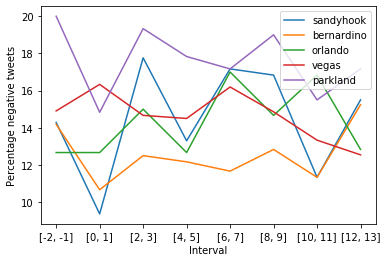

In [133]:
interval_length = 2
for shooting in SHOOTINGS:
  x = []
  y = []
  for i, day in enumerate(range(-2, 14, interval_length)):
    x.append(i)
    y.append(get_percent_negative_tweets(shooting, day, interval_length) * 100)
  print(shooting)
  print('x:', x)
  print('y:', y)
  plt.plot(x, y)
  plt.xlabel('Interval')
  my_xticks = ['[-2, -1]', '[0, 1]', '[2, 3]', '[4, 5]', '[6, 7]', '[8, 9]', '[10, 11]', '[12, 13]']
  plt.xticks(x, my_xticks)
  plt.ylabel('Percentage negative tweets')
  plt.legend(SHOOTINGS)

Tail graphs

sandyhook
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [15.151515151515149, 14.862385321100913, 15.600000000000003, 13.600000000000001, 11.66666666666667, 13.8, 16.800000000000004, 14.066666666666672, 16.933333333333334, 16.600000000000005, 13.666666666666671, 12.2]
bernardino
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [15.432742440041714, 11.93333333333333, 12.13333333333333, 12.196765498652296, 10.733333333333327, 17.41160773849233, 12.13333333333333, 10.614152202937255, 15.10695187165776, 15.066666666666661, 14.73333333333333, 11.86666666666667]
orlando
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [12.013536379018607, 13.8, 16.066666666666663, 13.86666666666667, 15.010006671114073, 13.33333333333333, 13.86666666666667, 14.720812182741117, 12.474983322214806, 13.008672448298864, 11.690046760187045, 13.208805870580386]
vegas
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [14.297800338409472, 15.066666666666661, 14.886515353805073, 13.489932885906041, 15.013404825737265, 16.08579088471

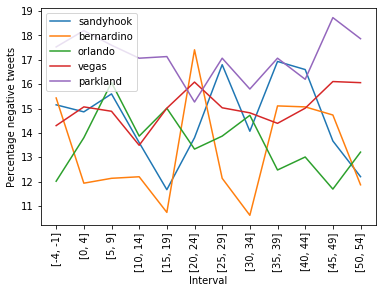

In [134]:
interval_length = 5
for shooting in SHOOTINGS:
  x = []
  y = []
  for i, day in enumerate(range(FIRST_DAY, LAST_DAY, interval_length)):
    x.append(i)
    if day == FIRST_DAY:
      y.append(get_percent_negative_tweets(shooting, day, interval_length - 1) * 100)
    else:
      y.append(get_percent_negative_tweets(shooting, day, interval_length) * 100)
  print(shooting)
  print('x:', x)
  print('y:', y)
  plt.plot(x, y)
  plt.xlabel('Interval')
  my_xticks = ['[-4, -1]', '[0, 4]', '[5, 9]', '[10, 14]', '[15, 19]', '[20, 24]', '[25, 29]', '[30, 34]', '[35, 39]', '[40, 44]', '[45, 49]', '[50, 54]']
  plt.xticks(x, my_xticks)
  plt.ylabel('Percentage negative tweets')
  plt.legend(SHOOTINGS)
  plt.xticks(rotation=90)